# Weapon Damage by Target

## Setting Up

In [1]:
import pandas as pd
import calendar
from weapon import max_shots, burst

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

## Data Merge

In [2]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Chance to Hit

Soldiers start with an Accuracy value between 40 and 70, giving an average of 55.

To get the change of hit this should by applied to the weapon accuracy. Just multiply them as proportions. So an average of 55 to a weapon of Accuracy 90 means 0.55 * 0.9 = 0.495 chance of hit.

In [3]:
weapon_attacks["chance_to_hit"] = weapon_attacks.apply(lambda x: x["accuracy"] / 100 * 0.55, axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760


## Derived Damage

In [4]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["expected_damage"] = weapon_attacks.apply(lambda x: x["damage"] * x["chance_to_hit"], axis=1)
weapon_attacks["clip_damage"] = weapon_attacks.apply(lambda x: x["capacity"] * x["damage"], axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks["turns_to_reload"] = weapon_attacks.apply(lambda x: x["capacity"] / x["turn_max_shots"], axis=1)
weapon_attacks["turn_damage_max"] = weapon_attacks.apply(lambda x: x["turn_max_shots"] * x["damage"], axis=1)
weapon_attacks["turn_damage_expected"] = weapon_attacks.apply(lambda x: x["turn_damage_max"] * x["chance_to_hit"], axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,32.175,90.0,1.269841,0.787500,114.285714,40.857143
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,18.942,588.0,1.250000,11.200000,52.500000,23.677500
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,19.844,616.0,1.250000,11.200000,55.000000,24.805000
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,21.648,672.0,1.250000,11.200000,60.000000,27.060000
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,7.392,588.0,7.500000,1.866667,315.000000,55.440000


## Damage to Target Type

### Data Merge

In [5]:
weapon_damages = weapon_attacks
weapon_damages = weapon_damages.append([weapon_damages] * (len(damage_modifiers.index)-1), ignore_index=True)
weapon_damages["key"] = weapon_damages.groupby(["weapon", "ammo", "fire_mode"]).cumcount()

targets = damage_modifiers["target"]

weapon_damages = pd.merge(weapon_damages, targets, left_on="key", right_index=True, how="left", sort=False)
weapon_damages = weapon_damages.drop(columns=["key"])
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,target
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,32.1750,90.0,1.269841,0.787500,114.285714,40.857143,terrain
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,18.9420,588.0,1.250000,11.200000,52.500000,23.677500,terrain
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,19.8440,616.0,1.250000,11.200000,55.000000,24.805000,terrain
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,21.6480,672.0,1.250000,11.200000,60.000000,27.060000,terrain
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,7.3920,588.0,7.500000,1.866667,315.000000,55.440000,terrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,0.6325,1,53.7625,680.0,1.333333,6.000000,113.333333,71.683333,zombie
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,0.3025,1,25.7125,680.0,2.222222,3.600000,188.888889,57.138889,zombie
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,0.6050,1,54.4500,90.0,1.269841,0.787500,114.285714,69.142857,zombie
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,0.3575,1,32.1750,90.0,2.040816,0.490000,183.673469,65.663265,zombie


### Damage vs Type

In [6]:
def damage_modifier(group):
    target = damage_modifiers[damage_modifiers["target"] == group["target"]]
    damage = target[group["damage_type"]].values[0]
    return damage / 100

In [7]:
weapon_damages["target_damage"] = weapon_damages.apply(damage_modifier, axis=1)
weapon_damages["target_damage"] = weapon_damages.apply(lambda x: x["damage"] * damage_modifier(x), axis=1)
weapon_damages["target_expected_damage"] = weapon_damages.apply(lambda x: x["expected_damage"] * damage_modifier(x), axis=1)
weapon_damages["target_clip_damage"] = weapon_damages.apply(lambda x: x["clip_damage"] * damage_modifier(x), axis=1)
weapon_damages["target_turn_damage_max"] = weapon_damages.apply(lambda x: x["turn_damage_max"] * damage_modifier(x), axis=1)
weapon_damages["target_turn_damage_expected"] = weapon_damages.apply(lambda x: x["turn_damage_expected"] * damage_modifier(x), axis=1)
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,...,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,target,target_damage,target_expected_damage,target_clip_damage,target_turn_damage_max,target_turn_damage_expected
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,...,1.269841,0.787500,114.285714,40.857143,terrain,90.0,32.175,90.0,114.285714,40.857143
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,...,1.250000,11.200000,52.500000,23.677500,terrain,42.0,18.942,588.0,52.500000,23.677500
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,...,1.250000,11.200000,55.000000,24.805000,terrain,44.0,19.844,616.0,55.000000,24.805000
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,...,1.250000,11.200000,60.000000,27.060000,terrain,48.0,21.648,672.0,60.000000,27.060000
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,...,7.500000,1.866667,315.000000,55.440000,terrain,42.0,7.392,588.0,315.000000,55.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,0.6325,...,1.333333,6.000000,113.333333,71.683333,zombie,68.0,43.010,544.0,90.666667,57.346667
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,0.3025,...,2.222222,3.600000,188.888889,57.138889,zombie,68.0,20.570,544.0,151.111111,45.711111
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,0.6050,...,1.269841,0.787500,114.285714,69.142857,zombie,0.0,0.000,0.0,0.000000,0.000000
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,0.3575,...,2.040816,0.490000,183.673469,65.663265,zombie,0.0,0.000,0.0,0.000000,0.000000


## Weapon Damages by Target

In [8]:
weapon_damages_targets = weapon_damages.groupby(["weapon", "target"]).max()
weapon_damages_targets = weapon_damages_targets[["target_turn_damage_expected"]]
weapon_damages_targets = weapon_damages_targets.rename(columns={"target_turn_damage_expected": "turn_damage"})
weapon_damages_targets = weapon_damages_targets.sort_values(by=["turn_damage"])
weapon_damages_targets

turn_damage
weapon         target                     
stun_rod       zombie             0.000000
small_launcher zombie             0.000000
grenade        cyberdisk         13.619048
               tank              17.023810
               zombie            18.158730
...                                    ...
heavy_plasma   tank             271.071429
               terrain          271.071429
               unarmored        271.071429
               personal_armor   271.071429
               snakeman         271.071429

[322 rows x 1 columns]

### Kinetic Weapons

Text(0, 0.5, 'Damage')

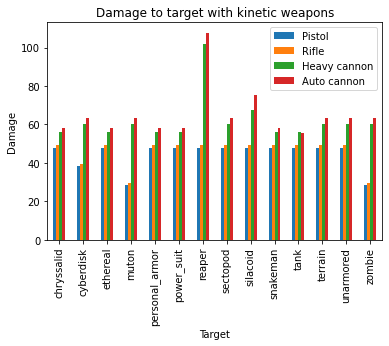

In [9]:
weapon_damages_targets_kinetic = weapon_damages_targets.loc[ ["pistol", "rifle", "heavy_cannon", "auto_cannon"] ]
weapon_damages_targets_kinetic = weapon_damages_targets_kinetic.swaplevel().unstack()
weapon_damages_targets_kinetic = weapon_damages_targets_kinetic.sort_values(by=["target"])
ax = weapon_damages_targets_kinetic.plot.bar(title="Damage to target with kinetic weapons")
ax.legend(["Pistol", "Rifle", "Heavy cannon", "Auto cannon"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Melee

Text(0, 0.5, 'Damage')

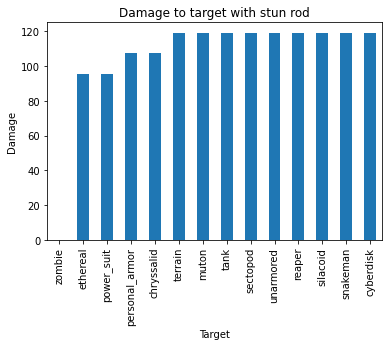

In [10]:
ax = weapon_damages_targets.loc[ "stun_rod" , : ].plot.bar(title="Damage to target with stun rod", legend=False)
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Explosive

Text(0, 0.5, 'Damage')

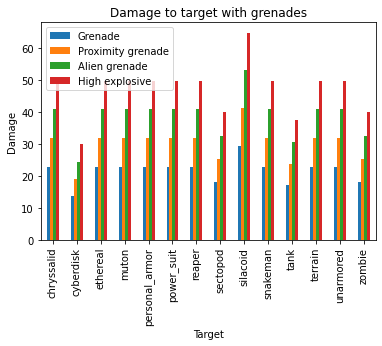

In [11]:
weapon_damages_targets_grenade = weapon_damages_targets.loc[ ["grenade", "proximity_grenade", "alien_grenade", "high_explosive"] ]
weapon_damages_targets_grenade = weapon_damages_targets_grenade.swaplevel().unstack()
weapon_damages_targets_grenade = weapon_damages_targets_grenade.sort_values(by=["target"])
ax = weapon_damages_targets_grenade.plot.bar(title="Damage to target with grenades")
ax.legend(["Grenade", "Proximity grenade", "Alien grenade", "High explosive"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

Text(0, 0.5, 'Damage')

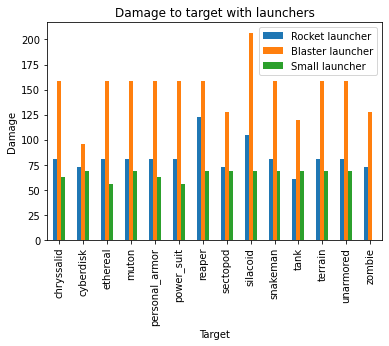

In [12]:
weapon_damages_targets_launcher = weapon_damages_targets.loc[ ["rocket_launcher", "blaster_launcher", "small_launcher"] ]
weapon_damages_targets_launcher = weapon_damages_targets_launcher.swaplevel().unstack()
weapon_damages_targets_launcher = weapon_damages_targets_launcher.sort_values(by=["target"])
ax = weapon_damages_targets_launcher.plot.bar(title="Damage to target with launchers")
ax.legend(["Rocket launcher", "Blaster launcher", "Small launcher"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Laser

Text(0, 0.5, 'Damage')

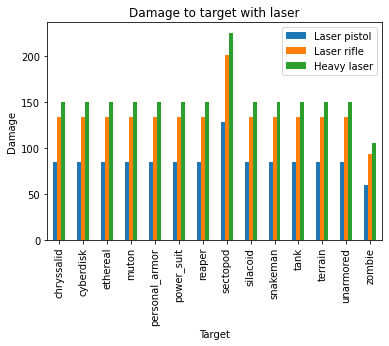

In [13]:
weapon_damages_targets_laser = weapon_damages_targets.loc[ ["laser_pistol", "laser_rifle", "heavy_laser"] ]
weapon_damages_targets_laser = weapon_damages_targets_laser.swaplevel().unstack()
weapon_damages_targets_laser = weapon_damages_targets_laser.sort_values(by=["target"])
ax = weapon_damages_targets_laser.plot.bar(title="Damage to target with laser")
ax.legend(["Laser pistol", "Laser rifle", "Heavy laser"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Plasma

Text(0, 0.5, 'Damage')

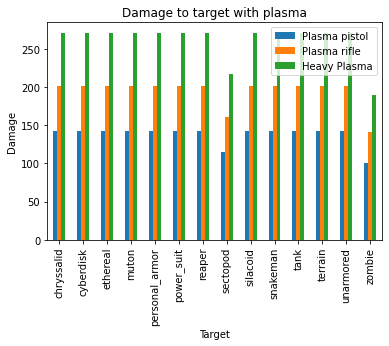

In [14]:
weapon_damages_targets_plasma = weapon_damages_targets.loc[ ["plasma_pistol", "plasma_rifle", "heavy_plasma"] ]
weapon_damages_targets_plasma = weapon_damages_targets_plasma.swaplevel().unstack()
weapon_damages_targets_plasma = weapon_damages_targets_plasma.sort_values(by=["target"])
ax = weapon_damages_targets_plasma.plot.bar(title="Damage to target with plasma")
ax.legend(["Plasma pistol", "Plasma rifle", "Heavy Plasma"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Tank

Text(0, 0.5, 'Damage')

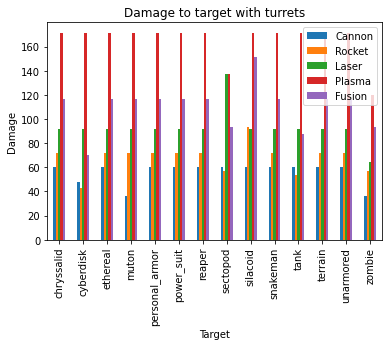

In [15]:
weapon_damages_targets_tank = weapon_damages_targets.loc[ ["cannon_turret", "rocket_turret", "laser_turret", "plasma_turret", "fusion_turret"] ]
weapon_damages_targets_tank = weapon_damages_targets_tank.swaplevel().unstack()
weapon_damages_targets_tank = weapon_damages_targets_tank.sort_values(by=["target"])
ax = weapon_damages_targets_tank.plot.bar(title="Damage to target with turrets")
ax.legend(["Cannon", "Rocket", "Laser", "Plasma", "Fusion"]);
ax.set_xlabel("Target")
ax.set_ylabel("Damage")

### Target Damage Lists

#### Averages

In [16]:
weapon_damages_averages = weapon_damages_targets.groupby(["weapon"]).mean()
weapon_damages_averages = weapon_damages_averages.sort_values(by=["turn_damage"])
weapon_damages_averages

,turn_damage
weapon,
grenade,21.482426
proximity_grenade,30.075397
alien_grenade,38.668367
pistol,44.261905
rifle,45.964286
high_explosive,47.261338
cannon_turret,55.714286
small_launcher,61.240816
heavy_cannon,61.828571


Text(0, 0.5, 'Damage')

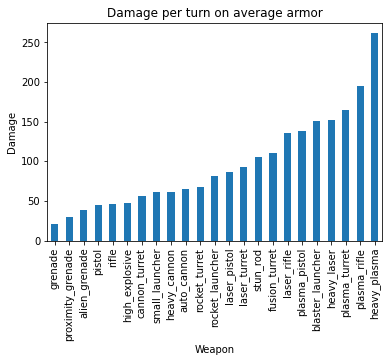

In [17]:
ax = weapon_damages_averages.plot.bar(title="Damage per turn on average armor", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Terrain

In [18]:
weapon_damages_terrain = weapon_damages_targets.xs("terrain", level="target")
weapon_damages_terrain = weapon_damages_terrain.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

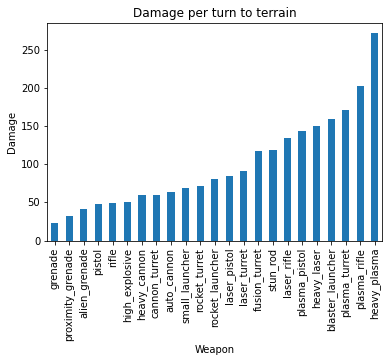

In [19]:
ax = weapon_damages_terrain.plot.bar(title="Damage per turn to terrain", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Unarmored

In [20]:
weapon_damages_unarmored = weapon_damages_targets.xs("unarmored", level="target")
weapon_damages_unarmored = weapon_damages_unarmored.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

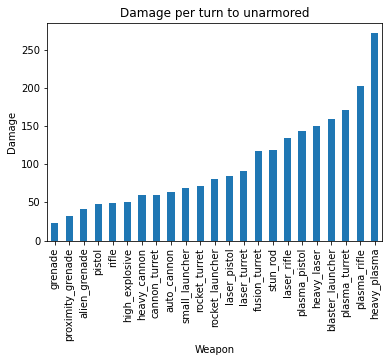

In [21]:
ax = weapon_damages_unarmored.plot.bar(title="Damage per turn to unarmored", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Personal Armor

In [22]:
weapon_damages_armor = weapon_damages_targets.xs("personal_armor", level="target")
weapon_damages_armor = weapon_damages_armor.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

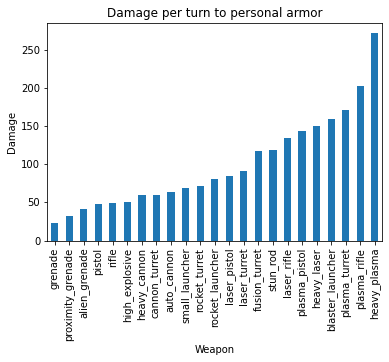

In [23]:
ax = weapon_damages_unarmored.plot.bar(title="Damage per turn to personal armor", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Power Suit

In [24]:
weapon_damages_power_suit = weapon_damages_targets.xs("power_suit", level="target")
weapon_damages_power_suit = weapon_damages_power_suit.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

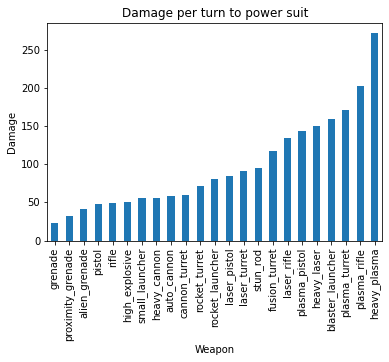

In [25]:
ax = weapon_damages_power_suit.plot.bar(title="Damage per turn to power suit", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Tank

In [26]:
weapon_damages_tank = weapon_damages_targets.xs("tank", level="target")
weapon_damages_tank = weapon_damages_tank.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

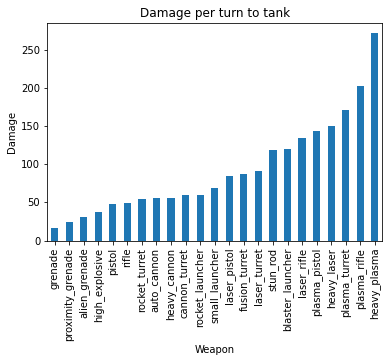

In [27]:
ax = weapon_damages_tank.plot.bar(title="Damage per turn to tank", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Snakeman

In [28]:
weapon_damages_snakeman = weapon_damages_targets.xs("snakeman", level="target")
weapon_damages_snakeman = weapon_damages_snakeman.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

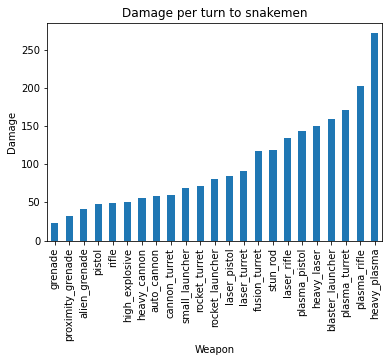

In [29]:
ax = weapon_damages_snakeman.plot.bar(title="Damage per turn to snakemen", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Ethereal

In [30]:
weapon_damages_ethereal = weapon_damages_targets.xs("ethereal", level="target")
weapon_damages_ethereal = weapon_damages_ethereal.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

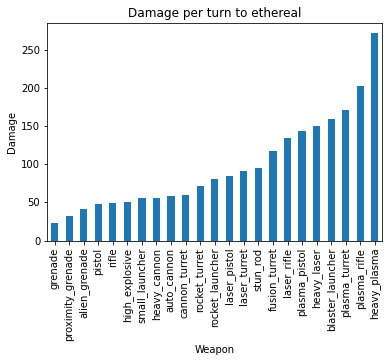

In [31]:
ax = weapon_damages_ethereal.plot.bar(title="Damage per turn to ethereal", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Muton

In [32]:
weapon_damages_muton = weapon_damages_targets.xs("muton", level="target")
weapon_damages_muton = weapon_damages_muton.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

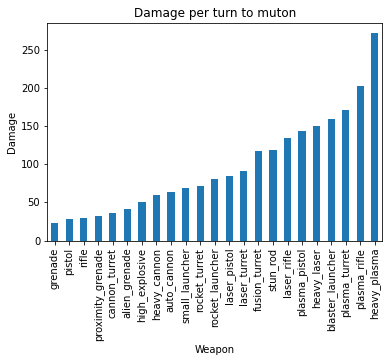

In [33]:
ax = weapon_damages_muton.plot.bar(title="Damage per turn to muton", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Silacoid

In [34]:
weapon_damages_silacoid = weapon_damages_targets.xs("silacoid", level="target")
weapon_damages_silacoid = weapon_damages_silacoid.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

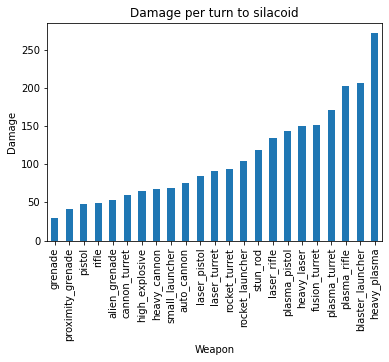

In [35]:
ax = weapon_damages_silacoid.plot.bar(title="Damage per turn to silacoid", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Chryssalid

In [36]:
weapon_damages_chryssalid = weapon_damages_targets.xs("chryssalid", level="target")
weapon_damages_chryssalid = weapon_damages_chryssalid.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

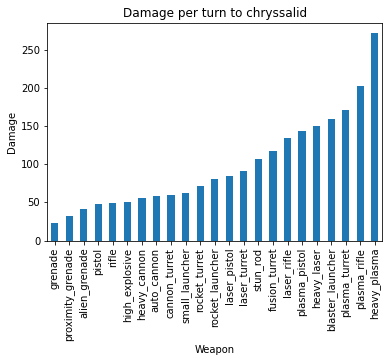

In [37]:
ax = weapon_damages_chryssalid.plot.bar(title="Damage per turn to chryssalid", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Reaper

In [38]:
weapon_damages_reaper = weapon_damages_targets.xs("reaper", level="target")
weapon_damages_reaper = weapon_damages_reaper.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

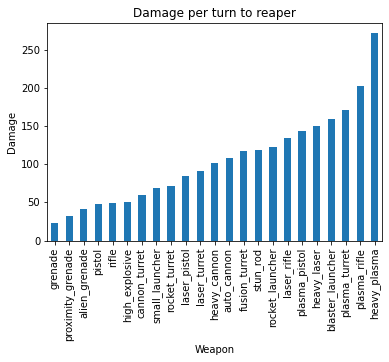

In [39]:
ax = weapon_damages_reaper.plot.bar(title="Damage per turn to reaper", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Sectopod

In [40]:
weapon_damages_sectopod = weapon_damages_targets.xs("sectopod", level="target")
weapon_damages_sectopod = weapon_damages_sectopod.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

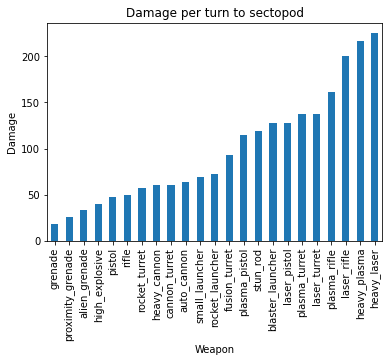

In [41]:
ax = weapon_damages_sectopod.plot.bar(title="Damage per turn to sectopod", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Cyberdisk

In [42]:
weapon_damages_cyberdisk = weapon_damages_targets.xs("cyberdisk", level="target")
weapon_damages_cyberdisk = weapon_damages_cyberdisk.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

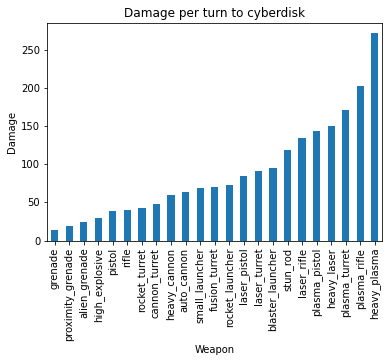

In [43]:
ax = weapon_damages_cyberdisk.plot.bar(title="Damage per turn to cyberdisk", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

#### Zombie

In [44]:
weapon_damages_zombie = weapon_damages_targets.xs("zombie", level="target")
weapon_damages_zombie = weapon_damages_zombie.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

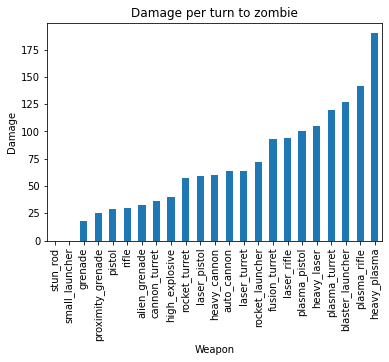

In [45]:
ax = weapon_damages_zombie.plot.bar(title="Damage per turn to zombie", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")